#### Imports

In [366]:
import math
import os
import re

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.image import imread
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, apply_affine_transform

%matplotlib inline

In [367]:
data_dir = './../images/valid_images'

In [368]:
image_file_names = os.listdir(data_dir)

#### Analyze images and normalize class label

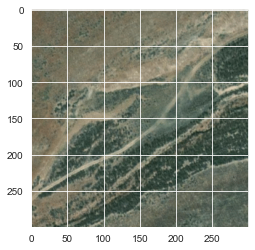

In [369]:
test_image = imread(f'{data_dir}/{image_file_names[0]}')
plt.imshow(test_image)

In [370]:
test_image.shape

(300, 300, 4)

In [371]:
test_image[:, :, 0]

array([[0.4509804 , 0.4509804 , 0.41960785, ..., 0.6431373 , 0.6666667 ,
        0.52156866],
       [0.41568628, 0.41568628, 0.44705883, ..., 0.67058825, 0.64705884,
        0.52156866],
       [0.4509804 , 0.44705883, 0.44705883, ..., 0.6431373 , 0.5803922 ,
        0.45490196],
       ...,
       [0.2901961 , 0.32156864, 0.39215687, ..., 0.3882353 , 0.38431373,
        0.35686275],
       [0.32156864, 0.38431373, 0.39215687, ..., 0.3882353 , 0.35686275,
        0.35686275],
       [0.32156864, 0.32156864, 0.39215687, ..., 0.38431373, 0.3882353 ,
        0.38431373]], dtype=float32)

In [372]:
image_file_names[0]

'WA_total_opportunity_1001.TIF_10022_0.0.png'

In [373]:
regex = re.compile('_([\d.e-]+)\.png')
regex.findall(image_file_names[0])[0]

'0.0'

In [374]:
image_dicts = []
length = len(image_file_names)
count = 1
for image_name in image_file_names:
    print(f'\r{count}/{length}', end='')
    row = {'name': image_name, 'value': float(regex.findall(image_name)[0])}
    image_dicts.append(row)
    count += 1
image_df = pd.DataFrame(image_dicts)

59270/59270

In [375]:
image_df

,name,value
0,WA_total_opportunity_1001.TIF_10022_0.0.png,0.0
1,WA_total_opportunity_1001.TIF_10268_0.0.png,0.0
2,WA_total_opportunity_1001.TIF_10477_0.0.png,0.0
3,WA_total_opportunity_1001.TIF_10611_0.0.png,0.0
4,WA_total_opportunity_1001.TIF_10648_0.0.png,0.0
...,...,...
59265,WA_total_opportunity_999.TIF_950_0.0.png,0.0
59266,WA_total_opportunity_999.TIF_9526_0.0.png,0.0
59267,WA_total_opportunity_999.TIF_9536_0.0.png,0.0
59268,WA_total_opportunity_999.TIF_9571_0.0.png,0.0


In [376]:
image_df['value']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
59265    0.0
59266    0.0
59267    0.0
59268    0.0
59269    0.0
Name: value, Length: 59270, dtype: float64

In [377]:
image_df['original_value'] = np.divide(np.multiply(54130, image_df['value']), np.add(image_df['value'], 1))
image_df['norm_value'] = np.divide(image_df['original_value'], 54130)
image_df.iloc[13290]

name              WA_total_opportunity_1802.TIF_2289_0.0.png
value                                                    0.0
original_value                                           0.0
norm_value                                               0.0
Name: 13290, dtype: object

c:\users\liams\anaconda3\envs\deep_learning_on_ray\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='norm_value', ylabel='Density'>

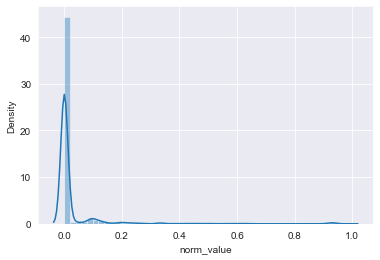

In [378]:
sns.distplot(image_df['norm_value'])

In [379]:
image_df['norm_value'].describe()

count    59270.000000
mean         0.028965
std          0.111873
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.982339
Name: norm_value, dtype: float64

In [425]:
sample_size = int(np.floor(len(image_df[image_df['norm_value'] == 0.0]) * 0.8))

In [426]:
sample = np.random.choice(image_df[image_df['norm_value'] == 0.0].index, size=sample_size, replace=False)
len(sample)

37181

In [427]:
# remove sample of images with no reforestation opp from input data
shortened_image_df = image_df.drop(sample)

In [428]:
shortened_image_df.describe()

,value,original_value,norm_value
count,22089.000000,22089.000000,22089.000000
mean,0.391964,4206.927475,0.077719
std,2.057325,9343.333452,0.172609
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000647,35.000000,0.000647
75%,0.102983,5054.000000,0.093368
max,55.621339,53174.000000,0.982339


c:\users\liams\anaconda3\envs\deep_learning_on_ray\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='norm_value', ylabel='Density'>

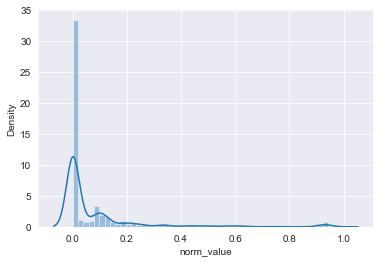

In [429]:
sns.distplot(shortened_image_df['norm_value'])

In [437]:
def right_angle_rotate(input_image):
    angle = np.random.choice([0, 90, 180, 270])
    if angle != 0:
        input_image = apply_affine_transform(
            input_image, theta=angle)
    return input_image

In [438]:
image_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=right_angle_rotate,
    validation_split=0.3,
    rescale=1/255
)

train_generator = image_datagen.flow_from_dataframe(
    dataframe=shortened_image_df,
    directory=data_dir,
    target_size=(300, 300),
    x_col='name',
    y_col='norm_value',
    color_mode='rgb',
    batch_size=2,
    seed=42,
    class_mode='raw',
    subset='training'
)

test_generator = train_generator = image_datagen.flow_from_dataframe(
    dataframe=shortened_image_df,
    directory=data_dir,
    target_size=(300, 300),
    x_col='name',
    y_col='norm_value',
    color_mode='rgb',
    batch_size=1,
    seed=42,
    class_mode='raw',
    subset='validation'
)

Found 15463 validated image filenames.
Found 6626 validated image filenames.


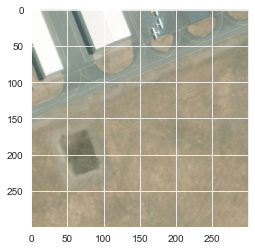

In [439]:
plt.imshow(train_generator[0][0].reshape(300, 300, 3))

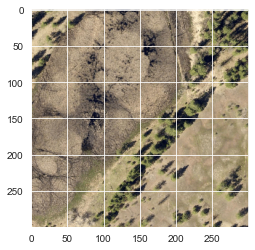

In [440]:
plt.imshow(train_generator[2000][0].reshape(300, 300, 3))

#### Train model

In [441]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(30,30),input_shape=(300, 300, 3), activation='relu',))
model.add(MaxPooling2D(pool_size=(25, 25)))

# model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
# model.add(MaxPooling2D(pool_size=(2, 2)))
#
# model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
# model.add(MaxPooling2D(pool_size=(2, 2)))
#
# model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(300, 300, 3), activation='relu',))
# model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

# model.add(Dense(2048, activation = 'relu'))
#
# model.add(Dense(1024, activation = 'relu'))

model.add(Dense(128, activation = 'relu'))

# model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [442]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 271, 271, 32)      86432     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 128)               409728    
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 129       
_________________________________________________________________
activation_26 (Activation)   (None, 1)                 0         
Total params: 496,289
Trainable params: 496,289
Non-trainable params: 0
_______________________________________________

In [443]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples,
    validation_data=test_generator,
    validation_steps=test_generator.samples,
    epochs=20
)
model.save(f'./../models/ncrp_reforestation_{model.name}')

Epoch 1/20
  43/6626 [..............................] - ETA: 22:55 - loss: 0.7572 - accuracy: 0.5116

KeyboardInterrupt: 

In [256]:
model.save(f'./../models/ncrp_reforestation_{model.name}.h5')